## Bayesian multivariate normal model

# Intuition
Bayesian multivariate normal model

**FIGURE PLACEHOLDER:** ![Bayesian multivariate normal model](image_placeholder)

# Definition

## Multivariate normal mean model

From [wikipedia](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) and [Matthew Stephen's note](http://stephens999.github.io/fiveMinuteStats/mvnorm.html), the multivariate normal mean model can be defined in this way:
> one definition is that a random vector is said to be $r$-variate normally distributed if every linear combination of its $r$ components has a univariate normal distribution.
>
> The special case $r=2$ is usually referred to as the “bivariate normal” distribution. And the terminology "$r$-dimensional multivariate normal" means the same as $r$-variate normal.

> Suppose $Z_1, \dots, Z_n$ are independent random variables each with a standard normal distribution $N(0,1)$. Let $Z$ denote the vector $(Z_1, \dots, Z_n)$, and let $A$ be any $r \times n$ matrix, and $\mu$ be any $r$-vector. Then the vector $X = A Z + \mu$ has an $r$-dimensional multivariate normal distribution with mean $\mu$ and variance-covariance matrix $\Sigma := A A'$. (Here $A'$ means the transpose of the matrix $A$.) We write $X \sim N_r(\mu, \Sigma)$.
>
> Note that $E(X_j) = \mu_j$ and $\text{cov}(X_i, X_j) = \Sigma_{ij}$.
> 
> When we simulate $X$ this way, any linear combination of the elements of $X$ is a linear combination of $Z$, and so is univariate normal because any linear combination of univariate normals is univariate normal. That is, when we simulate $X$ this way it satisfies the definition above for being $r$-variate normal.


# Example

## Description

We continue to use the Bayesian normal mean model example in lecture 7, but instead of comparing two models to assess the effect of **a single genetic variant** on a trait such as height, here **two genetic variants** are included in the model. This approach follows the Bayesian multivariate normal mean model, which provides a conjugate framework for inference.

1. **Model 1 ($M_1$)**: This model assumes that neither of the genetic variants has any effect on the trait. Assumes the trait $y$ is normally distributed with mean 0 (no genetic effect) and standard deviation $\sigma$.
$$
y_i \sim \mathcal{N}(0, \sigma^2)
$$
where $y_i$ ($i=1,...,n$) is the observed trait value for individual $i$.

2. **Model 2 ($M_2$)**: This model assumes that the genetic variants both has an effect on the trait. Assumes the trait is normally distributed with a non-zero mean (genetic effect $\beta_1$ and genetic effect $\beta_2$), where $x_{i,1}$ and $x_{i,2}$ are the genotype (coded as 0, 1, or 2 for the number of copies of the minor allele) for the first and second genetic variants, respectively.
  
$$
y_i \sim \mathcal{N}(\beta_1+\beta_2, \sigma^2)
$$

It is easy to realize that there could be more models -- for example, $M_3$ could be that the first variant has an effect but no effect for the second variant, and $M_4$ could be vice versa. This is a big advantage of Bayesian models versus frequensists model (null versus alternative) which we discussed in **[FIXME!!]**. In this notebook, we focus on the comparison between $M_1$ and $M_2$.

In [1]:
library(mvtnorm)
# Simulate true mean and effect size
mu_baseline <- 0  # population mean of the trait (e.g., height in cm) under Model 1
beta_1_true <- 0.7  # true effect size of the first genetic variant
beta_2_true <- 1.3  # true effect size of the second genetic variant
sigma <- 0.4  # standard deviation of the trait

set.seed(3)
# Simulate genotypes for two genetic variants
genotypes_1 <- c(0, 2, 1)
genotypes_2 <- c(1, 0, 2)
n <- length(genotypes_1)

# Simulate trait values based on the model 2
trait_values <- rnorm(n, mean = mu_baseline + beta_1_true * genotypes_1 + beta_2_true * genotypes_2, sd = sigma)

# Data preview
data.frame(genotype_1 = genotypes_1, genotype_2 = genotypes_2, trait = trait_values)


genotype_1,genotype_2,trait
<dbl>,<dbl>,<dbl>
0,1,0.9152266
2,0,1.2829897
1,2,3.4035153


## Bayesian Inference

We assume the normal priors for the effect sizes $\beta_1$ and $\beta_2$:
$$
\beta_1, \beta_2 \sim \mathcal{N}(\beta_0, 1/\tau_0),
$$
where $\beta_1$ and $\beta_2$ are the effect sizes for the two genetic variants, and $\beta_0$ is the prior mean, while $\tau_0$ is the prior precision.

Using Bayesian updating, the posterior distribution of $\beta_1$ and $\beta_2$ is given by:
$$
\begin{pmatrix}
\beta_1 \\
\beta_2
\end{pmatrix}
| X \sim \mathcal{N} \left( \begin{pmatrix} \beta_1^* \\ \beta_2^* \end{pmatrix}, \Sigma^* \right),
$$
where:
- The posterior precision matrix $\Sigma^*$ is the inverse of the sum of the prior precision matrix and the data precision matrix:
  $$
  \Sigma^* = \left( \tau_0 I + X^T X / \sigma^2 \right)^{-1},
  $$
  with $X$ being the matrix of genotype values, and $\sigma^2$ being the variance of the trait.
  
- The posterior mean vector $\begin{pmatrix} \beta_1^* \\ \beta_2^* \end{pmatrix}$ is given by:
  $$
  \begin{pmatrix} \beta_1^* \\ \beta_2^* \end{pmatrix}
  = \Sigma^* \left( \frac{1}{\sigma^2} X^T y + \tau_0 \beta_0 \right),
  $$
  where $y$ is the vector of observed trait values, and $X$ is the matrix of genotype values (with each column corresponding to the genotype of each individual for the two variants).

This framework allows us to update our belief about the effect sizes $\beta_1$ and $\beta_2$ after observing the trait data, incorporating both prior knowledge and observed data.


In [2]:
# Create a grid of beta values for beta_1 and beta_2
beta_vals_1 <- seq(-2, 2, length.out = 100)  # Grid for beta_1
beta_vals_2 <- seq(-2, 2, length.out = 100)  # Grid for beta_2
beta_grid <- expand.grid(beta_1 = beta_vals_1, beta_2 = beta_vals_2)

### Prior distribution

In [3]:
# Prior parameters for the multivariate model
mu_0 <- c(0, 0)  # Prior mean vector for beta_1 and beta_2
sigma_0 <- 0.5    # Prior standard deviation for both beta_1 and beta_2
tau_0 <- 1 / sigma_0^2  # Prior precision for both beta_1 and beta_2
Sigma_0 <- sigma_0^2 * diag(2)  # Prior covariance matrix (diagonal for independence)

# Compute prior densities for the multivariate normal
prior_density <- dmvnorm(beta_grid, mean = mu_0, sigma = Sigma_0)

# Print prior information
cat("Prior Information for beta_1 and beta_2:\n")
cat("Mean of mu_0:", mu_0, "\n")
cat("Standard Deviation (sigma_0):", sigma_0, "\n")
cat("Precision (tau_0 = 1/sigma_0^2):", tau_0, "\n")
cat("Covariance Matrix (Sigma_0):\n")
print(Sigma_0)


Prior Information for beta_1 and beta_2:
Mean of mu_0: 0 0 
Standard Deviation (sigma_0): 0.5 
Precision (tau_0 = 1/sigma_0^2): 4 
Covariance Matrix (Sigma_0):
     [,1] [,2]
[1,] 0.25 0.00
[2,] 0.00 0.25


### Likelihood

In [4]:
# Matrix of genotypes for two genetic variants
X <- cbind(genotypes_1, genotypes_2)

# Function to compute the likelihood for a given set of beta_1 and beta_2
likelihood_function <- function(beta_1, beta_2) {
  # Predicted trait values based on the current beta values
  predicted_trait_values <- X %*% c(beta_1, beta_2)  # Linear model: X*beta
  
  # Compute the likelihood (normal density for each data point)
  likelihood_values <- dnorm(trait_values, mean = predicted_trait_values, sd = sigma)
  
  # Return the product of likelihoods for all observations (log-likelihood is usually computed for stability)
  return(prod(likelihood_values))
}

# Apply the likelihood function to the grid of beta values
likelihood_values <- apply(beta_grid, 1, function(row) likelihood_function(row[1], row[2]))

### Posterior distribution

In [5]:
# Compute the unnormalized posterior by multiplying likelihood and prior
posterior_values <- likelihood_values * prior_density

# Normalize the posterior to get a proper probability distribution
posterior_values_normalized <- posterior_values / sum(posterior_values)

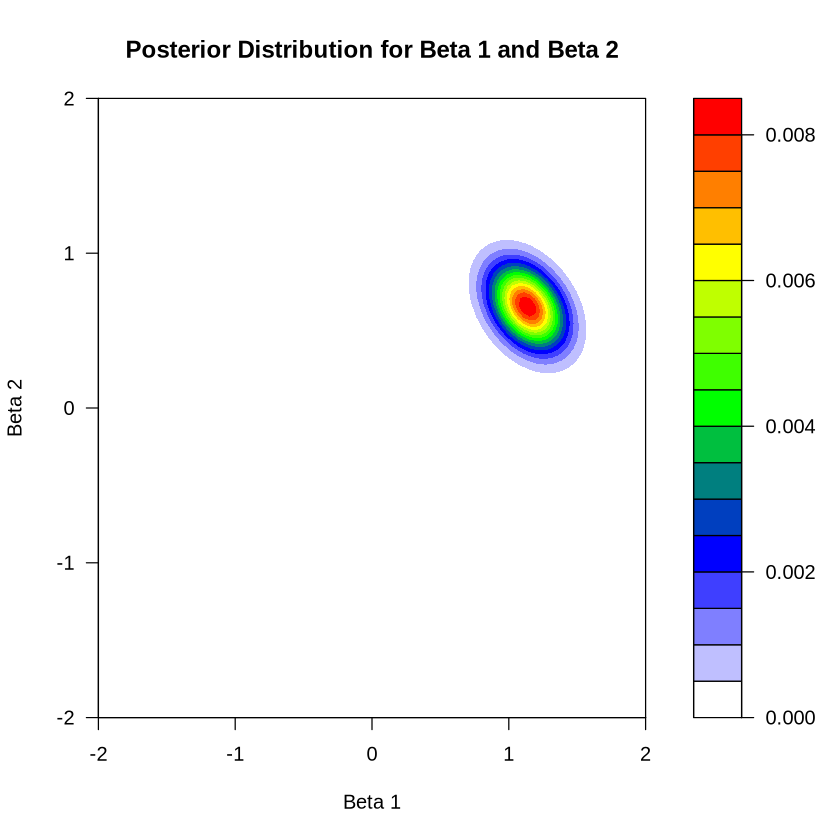

In [6]:
posterior_matrix <- matrix(posterior_values_normalized, nrow = length(beta_vals_1), byrow = TRUE)

# Plot posterior as a heatmap
filled.contour(beta_vals_1, beta_vals_2, posterior_matrix, 
               xlab = "Beta 1", ylab = "Beta 2", 
               main = "Posterior Distribution for Beta 1 and Beta 2",
               color.palette = colorRampPalette(c("white", "blue", "green", "yellow", "red")))
